In [1]:
from lib.abstract_torch import get_device, get_loss, get_optimizer
from lib.dataloader import get_MNIST_loaders
from lib.models import ANN, LoRA_ANN
from lib.train import train_ANN
from lib.test import test
from lib.save import save

import os
import numpy as np
import torch

In [28]:
train_vanilla = True

In [3]:
device = get_device()

In [4]:
path = os.path.dirname(os.path.abspath("__file__"))
data_path = path + "\\data"
model_path = path + "\\ANN_LoRA\\"

Playable HPs :
- LoRA rank
- trade-off

Other HPs :
- batch_size

In [5]:
# Data parameter
batch_size=128

# Network Architecture
num_inputs = 28*28
num_hidden = 100
num_outputs = 10

# Train parameters
loss_name = "CE"
optimizer_name = "Adam"

## Reproducibility

In [6]:
random_seed = 88

## Get MNIST loaders

In [7]:
# We train on MNIST 0 to 4, then each new task is being able to classify a new digit (5 to 9)

In [8]:
train_loaders_list, val_loaders_list, test_loaders_list = get_MNIST_loaders(data_path, batch_size, random_seed, 0.7)

<class 'torchvision.datasets.mnist.MNIST'>
<class 'torchvision.datasets.mnist.MNIST'>
<class 'torchvision.datasets.mnist.MNIST'>
<class 'torchvision.datasets.mnist.MNIST'>
<class 'torchvision.datasets.mnist.MNIST'>
<class 'torchvision.datasets.mnist.MNIST'>


## Train vanilla ANN on digits 0 to 4

In [9]:
if train_vanilla :
    train_loader = train_loaders_list[0]
    test_loader = test_loaders_list[0]

In [10]:
if train_vanilla :
    lr = 1e-3
    num_epochs = 2

In [11]:
if train_vanilla :
    model = ANN(num_inputs, num_hidden, num_outputs)

In [12]:
if train_vanilla :
    train_ANN(model, loss_name, optimizer_name, lr, train_loader, num_epochs, batch_size, device)

In [13]:
if train_vanilla :
    test(model, test_loader, batch_size, device)

## Save vanilla ANN

In [14]:
if train_vanilla :
    vanilla_path = model_path+"ICL5_state_dict_digits_0_to_4.pth"

In [15]:
if train_vanilla :
    save(vanilla_path, model)

## CL on digits 5 to 9 with LoRA

In [16]:
import optuna
from functools import partial
import matplotlib.pyplot as plt

In [17]:
def define_model(trial, model_path, params) :
    lora_rank = trial.suggest_int("lora_rank", 8, 16)
    alpha = trial.suggest_float("alpha", 0.5, 2)
    
    num_inputs, num_hidden, num_outputs, batch_size = params
    lora_ann_model = LoRA_ANN(lora_rank,
                              alpha, 
                              model_path, 
                              num_inputs, 
                              num_hidden, 
                              num_outputs,
                              batch_size)

    return lora_ann_model

def objective(task_number, model_path, params, device, trial) :
    # Define model
    lora_ann_model = define_model(trial, model_path, params).to(device)
    
    # Set HPs
    lr = trial.suggest_float("lr", 1e-5, 5e-4)
    num_epochs = trial.suggest_int("num_epochs", 1, 4)
    
    # Train
    batch_size = params[-1]
    
    task = task_names[task_number]
    train_loader = train_loaders[task_number]
    #val_loader = val_loaders[task_number]

    train_ANN(lora_ann_model, loss_name, optimizer_name, lr, train_loader, num_epochs, batch_size, device)
    
    # Test
    test_accs = np.zeros(task_number+1)
    for j in range(task_number+1) :
        test_acc = test(lora_ann_model, test_loaders[j], batch_size, device)
        test_accs[j] = test_acc
    
    # Compute score
    mu, sigma = np.mean(test_accs), np.std(test_accs)
    score = mu - sigma
    
    return score

In [18]:
def retrain_and_save_with_best_HPs (best_trial, i, model_path) :
    lora_rank  = best_trial.params["lora_rank"]
    alpha = best_trial.params["alpha"]
    lr = best_trial.params["lr"]
    num_epochs = best_trial.params["num_epochs"]
    
    lora_ann_model = LoRA_ANN(lora_rank,
                              alpha, 
                              model_path, 
                              num_inputs, 
                              num_hidden, 
                              num_outputs,
                              batch_size).to(device)

    # Train
    
    task = task_names[i]
    train_loader = train_loaders[i]
    val_loader = val_loaders[i]

    train_ANN(lora_ann_model, loss_name, optimizer_name, lr, train_loader, num_epochs, batch_size, device)
    
    # Test
    test_accs = np.zeros(10)
    for j in range(10) :
        test_acc = test(lora_ann_model, test_loaders[j], batch_size, device)
        test_accs[j] = test_acc
    
    # Save model
    fc1_update = lora_ann_model.model.fc1.weight + alpha*torch.mm(lora_ann_model.l1_lora_A, lora_ann_model.l1_lora_B).T
    lora_ann_model.model.fc1.weight = torch.nn.Parameter(fc1_update)
    
    fc2_update = lora_ann_model.model.fc2.weight + alpha*torch.mm(lora_ann_model.l2_lora_A, lora_ann_model.l2_lora_B).T
    lora_ann_model.model.fc2.weight = torch.nn.Parameter(fc2_update)
    
    model_path = path + f"ICL5_state_dict_digit_{i}.pth"
    save(model_path, lora_ann_model.model)
    
    return test_accs

In [19]:
# Compute scores of the model trained on the first task
model_path = path + "\\ANN_LoRA\\ICL5_state_dict_digits_0_to_4.pth"

lora_rank = 16 # The value of this parameters has no influence
alpha = 1.8 # The value of this parameter has no influence

lora_ann_model = LoRA_ANN(lora_rank,
                          alpha, 
                          model_path, 
                          num_inputs, 
                          num_hidden, 
                          num_outputs, 
                          batch_size).to(device)

# Test the model trained on digits 0 to 4
test_accs = np.zeros(10)
for j in range(5) :
    test_acc = test(lora_ann_model, test_loaders[j], batch_size, device)
    test_accs[j] = test_acc
        
# Initialize variable to store the best HPs and the scores
best_params = []
scores = [test_acc]
test_accs_matrix = [test_accs]
mean_test_accs_through_past_tasks = [test_acc]

for i in range(5,10) :
    print(f"Learning Task {i+1}")
    # Perform HPO
    storage = optuna.storages.InMemoryStorage()
    study = optuna.create_study(storage=storage,
                                study_name="The Search",
                                #sampler=
                                direction = "maximize")
    
    params = num_inputs, num_hidden, num_outputs, batch_size
    partial_objective = partial(objective, i, model_path, params, device)
    study.optimize(partial_objective,
                   n_trials=3,
                   timeout=3600)

    # Retrain and save a model with the best params
    best_trial = study.best_trial
    best_params.append(best_trial.params)
    test_accs = retrain_and_save_with_best_HPs(best_trial, i, model_path) 
    
    model_path = path + f"ICL5_state_dict_digit_{i}.pth"
    
    # Compute and store scores
    mu, sigma = np.mean(test_accs[:i+1]), np.std(test_accs[:i+1])
    score = mu - sigma
    
    scores.append(score)
    test_accs_matrix.append(test_accs)
    mean_test_accs_through_past_tasks.append(mu)

[I 2024-05-24 10:40:20,467] A new study created in memory with name: The Search


Learning Task 6


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.61it/s]
[I 2024-05-24 10:40:22,109] Trial 0 finished with value: -3.2482390375889736 and parameters: {'lora_rank': 16, 'alpha': 0.8641721294030519, 'lr': 0.0004308990607821105, 'num_epochs': 3}. Best is trial 0 with value: -3.2482390375889736.
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]
[I 2024-05-24 10:40:22,977] Trial 1 finished with value: 45.19582191603976 and parameters: {'lora_rank': 14, 'alpha': 1.6667352204049137, 'lr': 8.738214210485807e-05, 'num_epochs': 1}. Best is trial 1 with value: 45.19582191603976.
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.74it/s]
[I 2024-05-24 10:40:24,206] Trial 2 finished with value: 44.778639972817835 and parameters: {'lora_rank': 10, 'alpha': 1.7479693374868468, 'lr': 0.000176252036142911, 'num_

Learning Task 7


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.46it/s]
[I 2024-05-24 10:40:27,837] Trial 0 finished with value: 39.51129584751698 and parameters: {'lora_rank': 10, 'alpha': 1.6125862548062484, 'lr': 0.00016721777233986854, 'num_epochs': 4}. Best is trial 0 with value: 39.51129584751698.
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.34it/s]
[I 2024-05-24 10:40:29,748] Trial 1 finished with value: 45.463806253157635 and parameters: {'lora_rank': 12, 'alpha': 0.7681803198451926, 'lr': 0.0002553526973374286, 'num_epochs': 3}. Best is trial 1 with value: 45.463806253157635.
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.35it/s]
[I 2024-05-24 10:40:31,257] Trial 2 finished with value: -6.6934008555579005 and parameters: {'lora_rank': 16, 'alpha': 1.1346545578660827, 'lr': 0.00045946207540252206, 'nu

Learning Task 8


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.13it/s]
[I 2024-05-24 10:40:35,744] Trial 0 finished with value: 28.232409019411392 and parameters: {'lora_rank': 8, 'alpha': 1.5814027260491135, 'lr': 0.00011101179260422012, 'num_epochs': 3}. Best is trial 0 with value: 28.232409019411392.
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.11it/s]
[I 2024-05-24 10:40:37,897] Trial 1 finished with value: 37.20046277998143 and parameters: {'lora_rank': 16, 'alpha': 1.08243903885896, 'lr': 0.00015117405922507267, 'num_epochs': 3}. Best is trial 1 with value: 37.20046277998143.
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.13it/s]
[I 2024-05-24 10:40:40,041] Trial 2 finished with value: 26.926718460635342 and parameters: {'lora_rank': 14, 'alpha': 0.7577521669935716, 'lr': 3.310481246248343e-05, 'num_ep

Learning Task 9


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]
[I 2024-05-24 10:40:45,036] Trial 0 finished with value: 27.563846007844376 and parameters: {'lora_rank': 15, 'alpha': 1.1041396505860357, 'lr': 6.968663809665457e-05, 'num_epochs': 4}. Best is trial 0 with value: 27.563846007844376.
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]
[I 2024-05-24 10:40:47,687] Trial 1 finished with value: 24.509042165592895 and parameters: {'lora_rank': 12, 'alpha': 0.7935216842268042, 'lr': 1.3717382014135177e-05, 'num_epochs': 4}. Best is trial 0 with value: 27.563846007844376.
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.42it/s]
[I 2024-05-24 10:40:49,337] Trial 2 finished with value: 25.68704831791429 and parameters: {'lora_rank': 13, 'alpha': 1.5716895520052498, 'lr': 7.96689668655652e-05, 'num_

Learning Task 10


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]
[I 2024-05-24 10:40:54,696] Trial 0 finished with value: 4.724189751459868 and parameters: {'lora_rank': 16, 'alpha': 1.710298142087029, 'lr': 0.0001332808454209124, 'num_epochs': 4}. Best is trial 0 with value: 4.724189751459868.
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.24it/s]
[I 2024-05-24 10:40:56,489] Trial 1 finished with value: 19.184567249507758 and parameters: {'lora_rank': 16, 'alpha': 0.530520911962181, 'lr': 1.2701346236086103e-05, 'num_epochs': 2}. Best is trial 1 with value: 19.184567249507758.
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.34it/s]
[I 2024-05-24 10:40:58,697] Trial 2 finished with value: -14.118130834591563 and parameters: {'lora_rank': 11, 'alpha': 1.7722322380305333, 'lr': 0.0004253897115316232, 'num_e

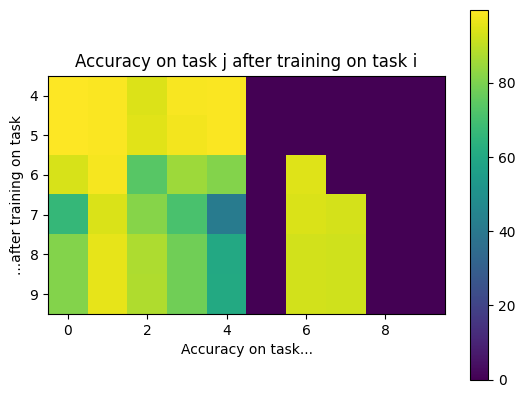

In [20]:
plt.imshow(test_accs_matrix, cmap='viridis', interpolation='nearest')
plt.yticks(np.arange(6), np.arange(4, 10))
plt.xlabel("Accuracy on task...")
plt.ylabel("...after training on task")
plt.title("Accuracy on task j after training on task i")
plt.colorbar()
plt.savefig("LoRA_greedy_HPO_matrix_ICL5.png")
plt.show()

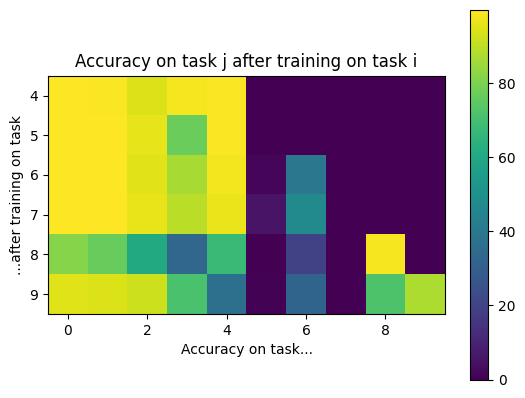

In [31]:
plt.imshow(test_accs_matrix, cmap='viridis', interpolation='nearest')
plt.yticks(np.arange(6), np.arange(4, 10))
plt.xlabel("Accuracy on task...")
plt.ylabel("...after training on task")
plt.title("Accuracy on task j after training on task i")
plt.colorbar()
plt.savefig("LoRA_greedy_HPO_matrix_ICL5.png")
plt.show()